In [1]:
import sys
import numpy as np
import pandas as pd

from sklearn.metrics import roc_auc_score as auc
from sklearn.preprocessing import LabelEncoder

In [2]:
class Split(object):
    def __init__(self, feature_id, threshold):
        self.feature_id = feature_id
        self.threshold = threshold
        
    def is_greater(self, example):
        return example[self.feature_id] > self.threshold
        
    def get_split(self, X, y):
        
        X_left = []
        y_left = []
        X_right = []
        y_right = []
        
        for i in xrange(len(X)):
            if self.is_greater(X[i]):
                X_right.append(X[i])
                y_right.append(y[i])
            else:
                X_left.append(X[i])
                y_left.append(y[i])
        
        return X_left, y_left, X_right, y_right

class Node(object):
    def __init__(self, feature_id, threshold):
        self.feature_id = feature_id
        self.threshold = threshold
        self.isLeaf = False
        self.resultTarget = None
        self.left = None
        self.right = None
        
    def toString(self, i):
        res = ""
        if self.isLeaf:
            res = res + " " * i + "Leaf. Result: " + str(self.resultTarget) + "\n"
        else:
            res = res + " " * i + "Feature: " + str(self.feature_id) + "\n" + " " * i + \
                    "Threshold: " + str(self.threshold) + "\n"
            res = res + self.left.toString(i + 2)
            res = res + self.right.toString(i + 2)
        return res
            
    def predict(self, x):
        if self.isLeaf:
            return self.resultTarget
        if x[self.feature_id] < self.threshold:
            return self.left.predict(x)
        else:
            return self.right.predict(x)
        
class DecisionTreeClassifier(object):
    
    def __init__(self, max_depth):
        self.root = None
        self.max_depth = max_depth
    
    def toString(self):
        return self.root.toString(1)
    
    def fit(self, X, y):
        self.root = self.make_node(X, y, 0)
        
    def make_node(self, X, y, level):
        if len(set(y)) == 1:
            node = Node(None, None)
            node.isLeaf = True
            node.resultTarget = y[0]
            return node
        
        if level == self.max_depth:
            node = Node(None, None)
            node.isLeaf = True
            node.resultTarget = max(set(y), key=y.count)
            return node
        
        best_g = sys.maxint
        best_feature = -1
        best_threshold = -1
        X = np.array(X)
        for i in xrange(len(X[0])):
            tresholds = list(set(X[:, i]))
            tresholds.sort()
            for t_m in [(tresholds[j] + tresholds[j + 1])/2 for j in range(len(tresholds) - 1)]:
                split = Split(i, t_m)
                X_l, y_l, X_r, y_r = split.get_split(X, y)
                g = self.G(X_l, y_l, X_r, y_r)
                if g < best_g:
                    best_g = g
                    best_feature = i
                    best_threshold = t_m
                    
        node = Node(best_feature, best_threshold)
        
        split = Split(best_feature, best_threshold)
        X_l, y_l, X_r, y_r = split.get_split(X, y)
        node.left = self.make_node(X_l, y_l, level+1)
        node.right = self.make_node(X_r, y_r, level+1)
        node.isLeaf = False
        return node
    
                
    def G(self, X_l, y_l, X_r, y_r):
        self.N = len(X_l) + len(X_r)
        return float(len(X_l)) / self.N * self.H(y_l) + float(len(X_r)) / self.N * self.H(y_r)
        
    def H(self, y):
        res = 0
        for k in set(y):
            res = res + self.p_k(y, k) * (1 - self.p_k(y, k))
        return res
    
    def p_k(self, y, k):
        res = 0
        for i in y:
            if i == k:
                res = res + 1
        return float(res) / self.N
        
    def predict(self, x):
        return self.root.predict(x)
        

In [4]:
data = pd.read_csv("german.data-numeric.txt", header=None, sep="\\s+")

In [7]:
target = data.loc[:,data.shape[1]-1].values
train_set = data.loc[:,0:(data.shape[1]-2)].values

In [8]:
X_test = []
y_test = []
X_fit = []
y_fit = []

for i in range(0, len(train_set), 2):
    X_test.append(train_set[i])
    y_test.append(target[i])

for i in range(1, len(train_set), 2):
    X_fit.append(train_set[i])
    y_fit.append(target[i])

In [13]:
clf = DecisionTreeClassifier(5)
clf.fit(X_fit, y_fit)

In [14]:
y_predict = [clf.predict(X_test[i]) for i in range(len(X_test))]

In [11]:
quality = sum(np.array(y_predict) == np.array(y_test)) / float(len(y_test))

print "Quality: ", quality

Quality:  0.644


In [15]:
lbl_enc = LabelEncoder()
auc(lbl_enc.fit_transform(y_test), lbl_enc.fit_transform(y_predict))

0.60436173533083648

In [17]:
auc_list = []
for i in range(1,21):
    auc_meaner = []
    # это чтобы хоть чуть усреднить оценки
    for j in range(1,5):
        clf = DecisionTreeClassifier(max_depth=i)
        clf.fit(X_fit, y_fit)
        y_predicted = [clf.predict(X_test[i]) for i in range(len(X_test))]
        auc_meaner.append(auc(lbl_enc.fit_transform(y_test), lbl_enc.fit_transform(y_predicted)))
    auc_list.append(np.mean(auc_meaner))

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

C:\Installed\Anaconda2\lib\site-packages\matplotlib\__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


### График AUC в зависимости от глубины дерева

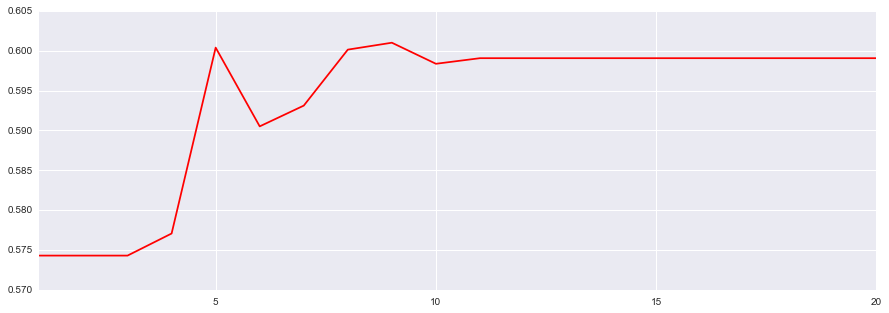

In [20]:
pd.Series(index=range(1,21), data=auc_list).plot(color='r', figsize=(15,5))

### AUC получается около 0.6. На самом деле это не так уж плохо, явно лучше чем случайный выбор.